In [1]:
# Standard library imports (built-in modules)
import os
import sys
import json
import yaml
import h5py
import random
from pathlib import Path
from typing import Tuple, Any, Optional

# Third-party libraries (numerical computing, data processing, and visualization)
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

# Whole Slide Imaging (WSI) processing
import openslide  

# Data visualization and specialized plots
from pySankey.sankey import sankey

# FastAI for deep learning
from fastai.vision.all import *

# Custom libraries (ensure correct path for project-specific utilities)
sys.path.append('/scratch/users/k21066795/RandStainNA')
from randstainna import RandStainNA

sys.path.append("/scratch/users/k21066795/BreastAgeNet")
from utils_model import *
from utils_vis import *

In [2]:
save_prefix = '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/figures/Fig5'

In [3]:
# load full test results of the test_BRCA dataset
BRCA_features = pd.read_csv("/scratch/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/main/test_full/test_BRCA_clean_10repeats.csv")
BRCA_df = get_averaged_outputs(BRCA_features)
BRCA_df

wsi_id patient_id cohort source  age  age_group  branch_0  \
0        T18-08826 I1  T18-08826    NKI    RRM   29          0 -2.458143   
1      22003431_FPE_2   22003431    KHP    RRM   32          0  1.016608   
2      22002145_FPE_1   22002145    KHP    RRM   30          0  0.546992   
3      21002311_FPE_3   21002311    KHP    RRM   29          0  3.152566   
4      22003423_FPE_2   22003423    KHP    RRM   32          0 -0.406976   
...               ...        ...    ...    ...  ...        ...       ...   
29133  22001590_FPE_2   22001590    KHP    RRM   58          3  3.215501   
29143  21002306_FPE_3   21002306    KHP    RRM   55          3  3.725980   
29155  22003409_FPE_1   22003409    KHP    RRM   55          3  5.313384   
29156  22001590_FPE_3   22001590    KHP    RRM   58          3  3.675952   
29248  22001589_FPE_1   22001589    KHP    RRM   58          3  5.078475   

       branch_1  branch_2  sigmoid_0  sigmoid_1  sigmoid_2  binary_0  \
0     -4.172930 -7.787188   0.078845   0.015173   0.000415         0   
1      0.022938 -3.161962   0.734311   0.505734   0.040623         1   
2     -0.642089 -3.456919   0.633438   0.344775   0.030563         1   
3      0.976199 -2.714239   0.959010   0.726353   0.062138         1   
4     -1.556447 -5.982891   0.399637   0.174157   0.002515         0   
...         ...       ...        ...        ...        ...       ...   
29133 -0.073638 -5.477756   0.961413   0.481599   0.004161         1   
29143  2.120604 -1.149064   0.976477   0.892890   0.240660         1   
29155  3.708886  2.747865   0.995099   0.976081   0.939793         1   
29156  2.317341  1.766592   0.975300   0.910303   0.854033         1   
29248  3.902876  2.409652   0.993809   0.980216   0.917560         1   

       binary_1  binary_2  final_prediction  
0             0         0                 0  
1             1         0                 2  
2             0         0                 1  
3             1         0                 2  
4             0         0                 0  
...         ...       ...               ...  
29133         0         0                 1  
29143         1         0                 2  
29155         1         1                 3  
29156         1         1                 3  
29248         1         1                 3  

[250 rows x 16 columns]

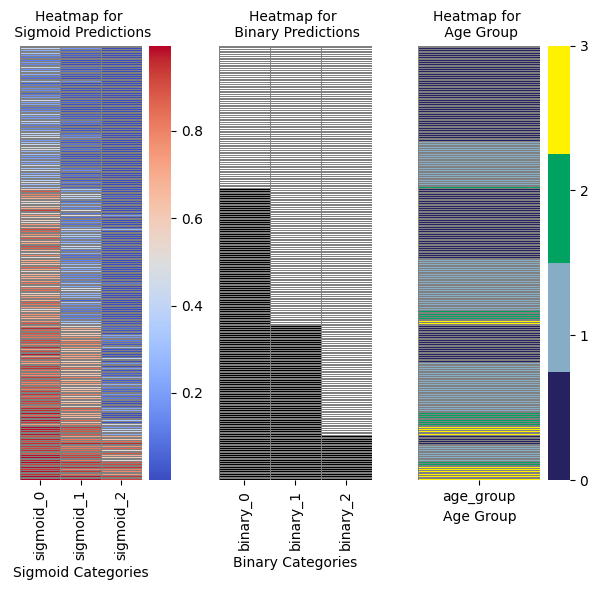

In [29]:
# Heatmaps visualising branch and overall tissue ageing predictions
BRCA_df = BRCA_df.sort_values(by=["binary_0", "binary_1", "binary_2"], ascending=[True, True, True])
save_pt = f'{save_prefix}/Test_BRCA_branch_predictions.pdf'
vis_branch_predictions(BRCA_df, save_pt=save_pt)

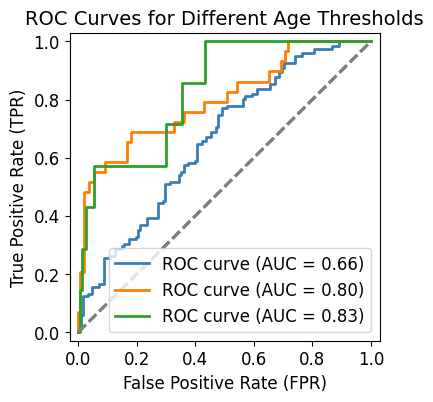

In [6]:
# ROC curves assessing branch performance
colors = ["#377EB8", "#4DAF4A", "#FF7F00"]  # Blue, Green, Orange

fig, ax = plt.subplots(figsize=(4, 4))  

branch_ROC(BRCA_df, branch=0, class_name=">rank0", ax=ax, fontsize=12, line_thickness=2)
branch_ROC(BRCA_df, branch=1, class_name=">rank1", ax=ax, fontsize=12, line_thickness=2)
branch_ROC(BRCA_df, branch=2, class_name=">rank2", ax=ax, fontsize=12, line_thickness=2)

for line, color in zip(ax.get_lines(), colors):
    line.set_color(color)

ax.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)  
ax.set_xlim([-0.03, 1.03])  # Add padding beyond 0-1 range
ax.set_ylim([-0.03, 1.03])  # Add padding beyond 0-1 range
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax.set_title('ROC Curves for Different Age Thresholds', fontsize=14)
ax.legend(loc="lower right", fontsize=12)

save_pt = f'{save_prefix}/Test_BRCA_multiple_ROCs_combined.pdf'
plt.savefig(save_pt, format='pdf')
plt.show()

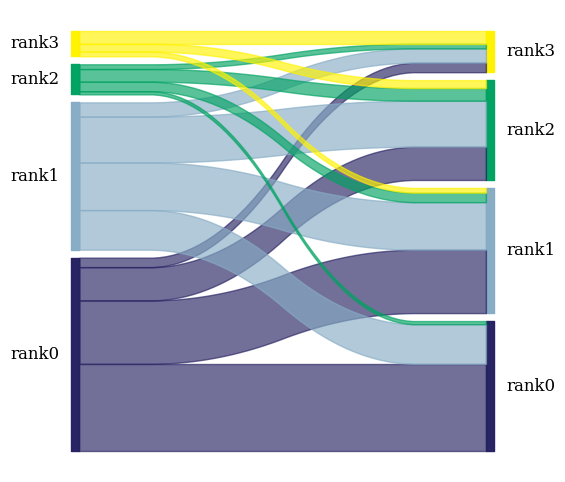

In [30]:
# Sankey diagram visualising the mapping between ground-truth and prediction
BRCA_df = BRCA_df.sort_values(by=["age_group", "final_prediction"])

y_true = [f"rank{i}" for i in list(BRCA_df["age_group"])]
y_pred = [f"rank{i}" for i in list(BRCA_df["final_prediction"])]
colors = {'rank0': "#262262", 'rank1': "#87ACC5", 'rank2': "#00A261", 'rank3': "#FFF200"}
sankey(y_true, y_pred, aspect=20, colorDict=colors, fontsize=12)

plt.savefig(f'{save_prefix}/Test_BRCA_sankey.pdf', format="pdf", dpi=300, transparent=True)

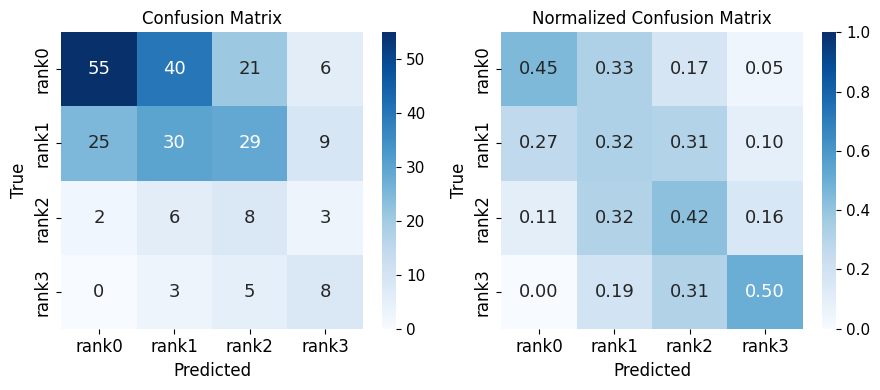

In [32]:
# Plot confusion matrix
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans"]

y_true = [f"rank{i}" for i in BRCA_df.loc[:, "age_group"].values]
y_pred = [f"rank{i}" for i in BRCA_df.loc[:, "final_prediction"].values]

fig, axes = plt.subplots(1, 2, figsize=(9, 4)) 
plot_cm(y_true, y_pred, fontsize=12, save_pt=f'{save_prefix}/Test_BRCA_cm.pdf', ax=axes[0])
plot_cm_norm(y_true, y_pred, fontsize=12, save_pt=f'{save_prefix}/Test_BRCA_cm_prop.pdf', ax=axes[1])
plt.tight_layout()
plt.show()

In [40]:
# get pathologist's evaluation
def extract_patient_id(external_id):
    if "_FPE_" in external_id:
        return external_id.split("_FPE_")[0]
    elif " " in external_id:
        return external_id.split(" ")[0]
    return external_id  # Default to full ID if no match


file_path = "/scratch/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/Exportproject_RRM_1.25x _1_28_2025.ndjson"
data = []
with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        json_obj = json.loads(line.strip())

        slide_id = json_obj["data_row"]["id"]
        external_id = json_obj["data_row"]["external_id"]
        classifications = json_obj.get("projects", {}).values()

        for project in classifications:
            for label in project.get("labels", []):
                for classification in label.get("annotations", {}).get("classifications", []):
                    checklist_answers = classification.get("checklist_answers", [])
                    
                    if len(checklist_answers) > 1:
                        name = "N/A"
                    else:
                        name = checklist_answers[0].get("name", "N/A")

                    data.append([slide_id, external_id, name])

pathologist_df = pd.DataFrame(data, columns=["Slide ID", "External ID", "Classification Name"])
pathologist_df = pathologist_df.loc[pathologist_df['Classification Name'] != 'N/A', :]
pathologist_df["patient_id"] = pathologist_df["External ID"].apply(extract_patient_id)
pathologist_df["wsi_id"] = [i.split('.png')[0] for i in list(pathologist_df['External ID'])]
pathologist_df['pathologist_rank'] = pathologist_df['Classification Name'].map({'<35y': 'rank0', '35-45y': 'rank1', '45-55y': 'rank2', '>55y': 'rank3'})

pathologist_df = pd.merge(pathologist_df, BRCA_df, on='wsi_id', how='left')
age_rank_map = {'<35y': "rank0", '35-45y': "rank1", '45-55y': "rank2", '>55y': "rank3"}
pathologist_df["age_group"] = [f"rank{i}" for i in list(pathologist_df["age_group"])]
pathologist_df

Slide ID         External ID Classification Name  \
0    cm6624pk90tsk0719pnkkgu5i  21002312_FPE_3.png              35-45y   
1    cm6624pk90tsl0719vjoscn7z    T16-05361 A1.png                >55y   
2    cm6624pk90tsm0719vs7hq6jr    T15-01254 A9.png                >55y   
3    cm6624pk90tsn0719kc568lr6  22003418_FPE_2.png              35-45y   
4    cm6624pk90tso0719d4qh9cxv  21002306_FPE_3.png              45-55y   
..                         ...                 ...                 ...   
231  cm6624pk90tz40719373922kr  22003428_FPE_1.png                <35y   
232  cm6624pk90tz507195epyv1dj  22003425_FPE_2.png                >55y   
233  cm6624pk90tz607195g8kmwdq  22003431_FPE_2.png              35-45y   
234  cm6624pk90tz70719fetednqq  21002303_FPE_1.png              35-45y   
235  cm6624pk90tz80719miq2varn  22003410_FPE_3.png              35-45y   

    patient_id_x          wsi_id pathologist_rank patient_id_y cohort source  \
0       21002312  21002312_FPE_3            rank1     21002312    KHP    RRM   
1      T16-05361    T16-05361 A1            rank3    T16-05361    NKI    RRM   
2      T15-01254    T15-01254 A9            rank3    T15-01254    NKI    RRM   
3       22003418  22003418_FPE_2            rank1     22003418    KHP    RRM   
4       21002306  21002306_FPE_3            rank2     21002306    KHP    RRM   
..           ...             ...              ...          ...    ...    ...   
231     22003428  22003428_FPE_1            rank0     22003428    KHP    RRM   
232     22003425  22003425_FPE_2            rank3     22003425    KHP    RRM   
233     22003431  22003431_FPE_2            rank1     22003431    KHP    RRM   
234     21002303  21002303_FPE_1            rank1     21002303    KHP    RRM   
235     22003410  22003410_FPE_3            rank1     22003410    KHP    RRM   

     age  ... sigmoid_0  sigmoid_1  sigmoid_2  binary_0  binary_1  binary_2  \
0     29  ...  0.921247   0.739194   0.503628         1         1         1   
1     44  ...  0.197222   0.039568   0.001162         0         0         0   
2     43  ...  0.481151   0.125239   0.002177         0         0         0   
3     35  ...  0.953582   0.861657   0.514095         1         1         1   
4     55  ...  0.976477   0.892890   0.240660         1         1         0   
..   ...  ...       ...        ...        ...       ...       ...       ...   
231   36  ...  0.214146   0.021240   0.000901         0         0         0   
232   33  ...  0.831661   0.762878   0.178537         1         1         0   
233   32  ...  0.734311   0.505734   0.040623         1         1         0   
234   34  ...  0.678609   0.201137   0.003501         1         0         0   
235   55  ...  0.943506   0.799671   0.797791         1         1         1   

     final_prediction  branch0_truth  branch1_truth  branch2_truth  
0                   3              0              0              0  
1                   0              1              0              0  
2                   0              1              0              0  
3                   3              0              0              0  
4                   2              1              1              0  
..                ...            ...            ...            ...  
231                 0              1              0              0  
232                 2              0              0              0  
233                 2              0              0              0  
234                 1              0              0              0  
235                 3              1              1              0  

[236 rows x 24 columns]

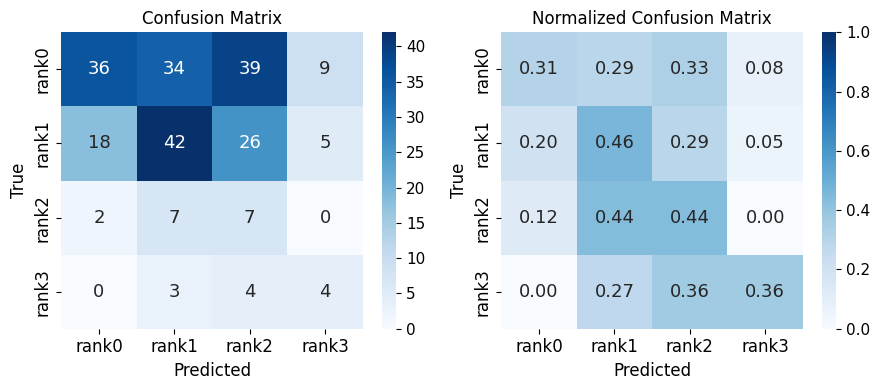

In [41]:
# plot confusion matrix
ordered_categories = ['rank0', 'rank1', 'rank2', 'rank3']
pathologist_df['age_group'] = pd.Categorical(pathologist_df['age_group'], categories=ordered_categories, ordered=True)
pathologist_df['pathologist_rank'] = pd.Categorical(pathologist_df['pathologist_rank'], categories=ordered_categories, ordered=True)

y_true = pathologist_df["age_group"]
y_pred = pathologist_df["pathologist_rank"]

fig, axes = plt.subplots(1, 2, figsize=(9, 4))  
plot_cm(y_true, y_pred, fontsize=12, save_pt=f'{save_prefix}/Test_BRCA_cm_pathologist.pdf', ax=axes[0])
plot_cm_norm(y_true, y_pred, fontsize=12, save_pt=f'{save_prefix}/Test_BRCA_cm_prop_pathologist.pdf', ax=axes[1])
plt.tight_layout()
plt.show()

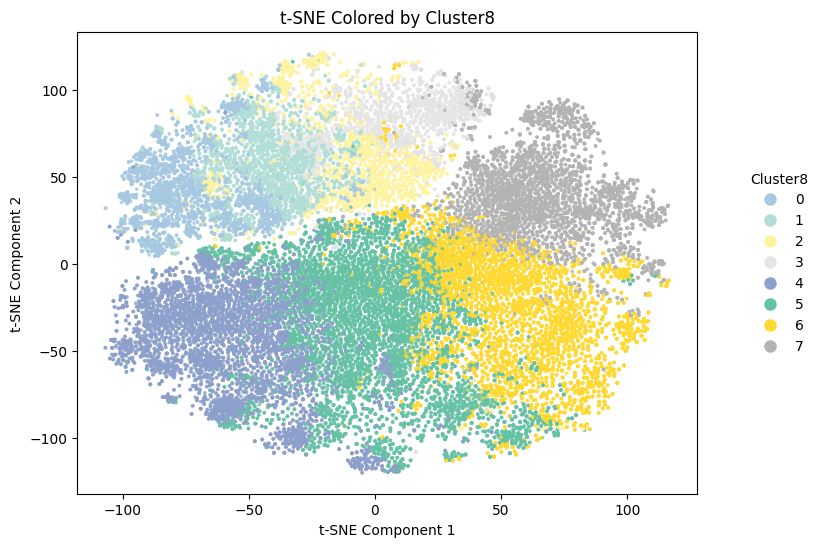

In [67]:
# Perform t-SNE
tsne_df = BRCA_features.copy()
embedding_columns = [col for col in tsne_df.columns if col.startswith('embedding_')]
tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(tsne_df.loc[:, embedding_columns])
tsne_df["tsne1"] = -projections[:,0]
tsne_df["tsne2"] = -projections[:,1]


# Perform Kmeans initially with right clusters
n_clusters = 8  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
tsne_df['Cluster8'] = kmeans.fit_predict(tsne_df.loc[:, embedding_columns].copy())


custom_palette = {0: '#A6C8E1', 1: '#B1DED6', 2: '#FEF39E', 3: '#E5E5E5', 
                  4: '#8da0cb', 5: '#66c2a5', 6: '#ffd92f', 7: '#b3b3b3'}
plot_tsne(tsne_df, color='Cluster8', custom_palette=custom_palette, figsize=(8, 6), point_size=3, alpha=0.7, save_pt=None, ax=None)

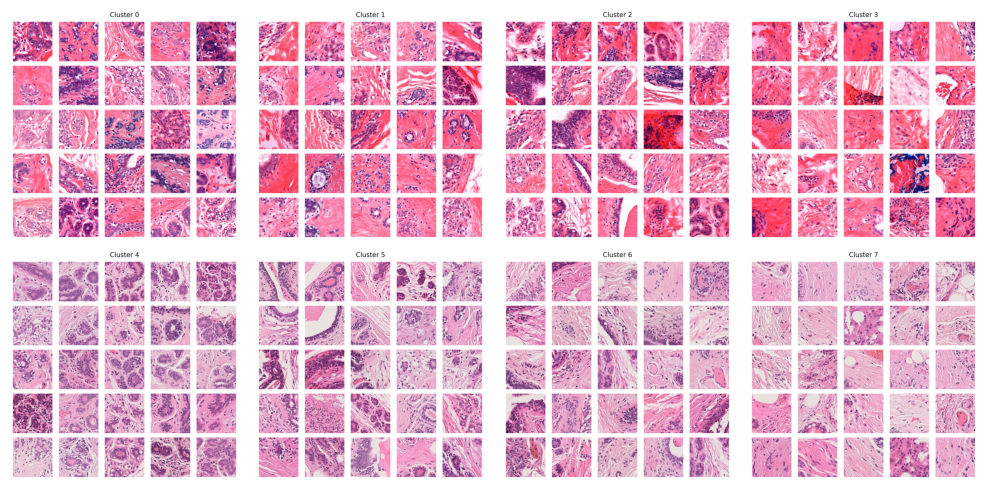

In [78]:
# visualise cluster examples
fig, axs = plt.subplots(2, 4, figsize=(10, 5)) 
axs = axs.flatten()

for cluster_id in range(8):
    cluster_imgs = get_Cluster_example(tsne_df, label='Cluster8', cluster_id=cluster_id, im_num=25)

    save_pt = f"{save_prefix}/test_BRCA_Cluster{cluster_id}_examples.png"
    plot_multiple(cluster_imgs, caption_list=None, grid_x=5, grid_y=5, figure_size=(8, 8), title=f"Cluster {cluster_id}", save_pt=save_pt)

    im = Image.open(save_pt)
    axs[cluster_id].imshow(im)
    axs[cluster_id].axis('off')  
    
plt.tight_layout()
plt.savefig(f"{save_prefix}/test_BRCA_8clusters_grids.png", dpi=300, bbox_inches='tight')
plt.show()

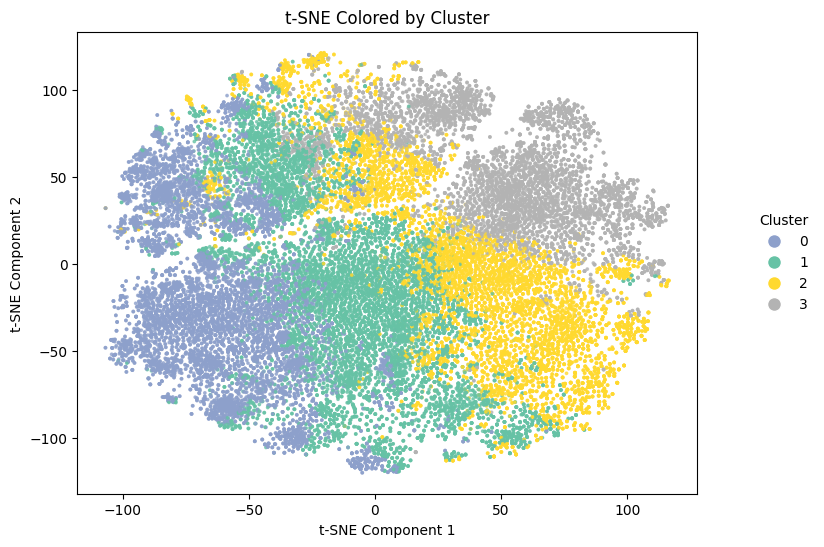

In [68]:
# mapping into the identified four clusters
tsne_df['Cluster'] = tsne_df['Cluster8'].map(cluster_mapping)

# t-SNE visualisation
plot_tsne(tsne_df, color='Cluster', figsize=(8, 6), point_size=3, alpha=0.7, save_pt=None, ax=None)

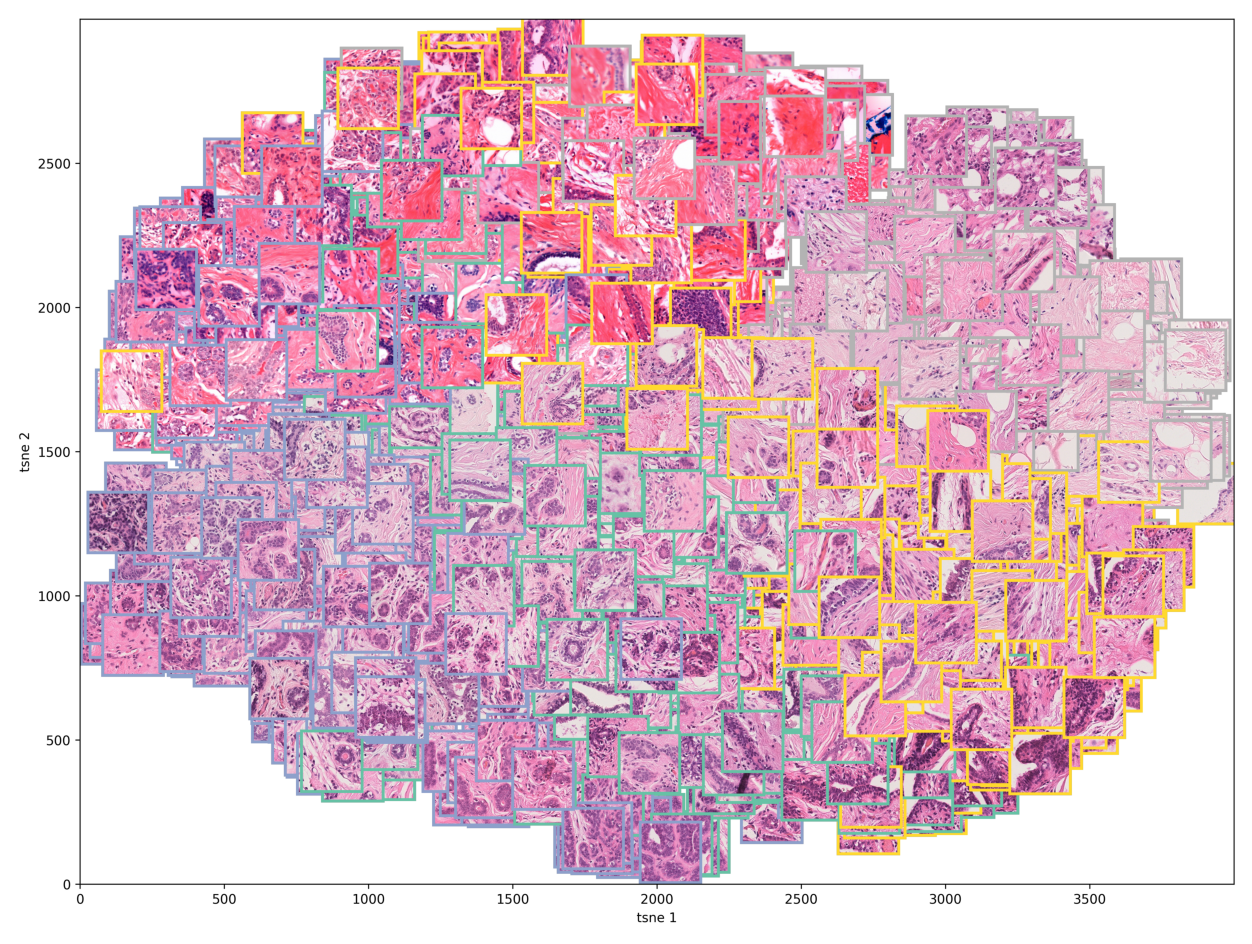

In [49]:
# overlayed H&E images
cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}
full_image = paste_HE_on_tsne(tsne_df=tsne_df, WSI_folder='/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs',
                     cluster_colors=cluster_colors, max_dim=200, n_samples=500, image_size=(4000, 3000), random_state=42)

plt.figure(figsize=(16, 12))
plt.imshow(full_image)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.gca().invert_yaxis()  
save_pt = f"{save_prefix}/test_BRCA_tsne_HEoverlay.png"
plt.savefig(fname = save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

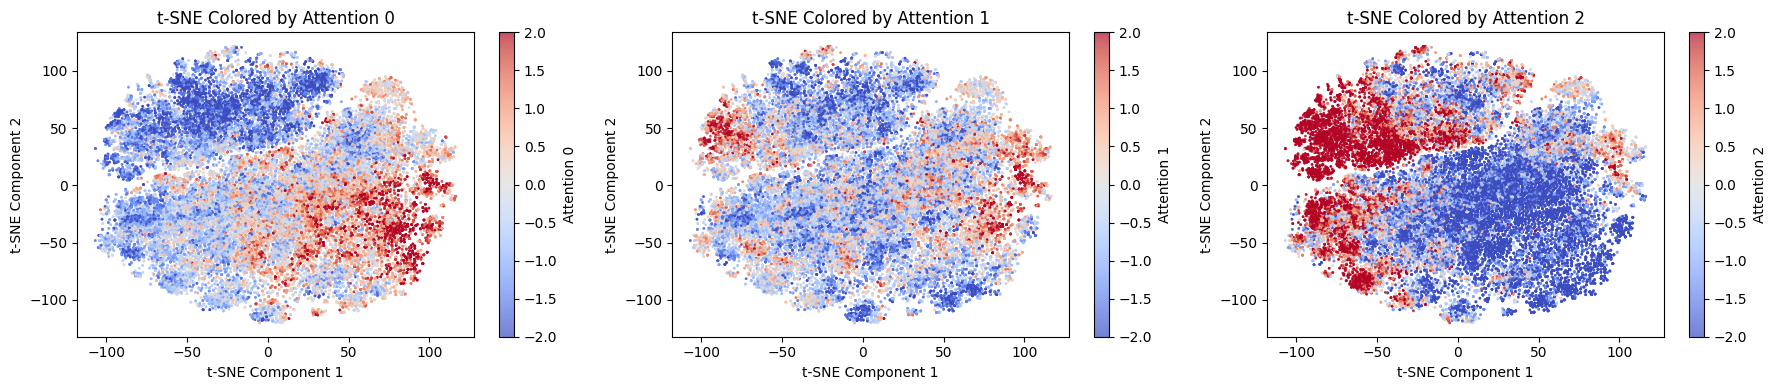

In [6]:
# t-SNE visualisation of branch-specific attention scores
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  

plot_tsne(tsne_df, color='attention_0', vmin=-2, vmax=2, point_size=1, ax=axes[0])
plot_tsne(tsne_df, color='attention_1', vmin=-2, vmax=2, point_size=1, ax=axes[1])
plot_tsne(tsne_df, color='attention_2', vmin=-2, vmax=2, point_size=1, ax=axes[2])

plt.tight_layout()
save_pt = f"{save_prefix}/test_BRCA_attentions_tsne.png"
plt.savefig(save_pt, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [69]:
# save clustering results
tsne_df['Pattern'] = [f"P{i}" for i in list(tsne_df['Cluster'])]
tsne_df.to_csv(f"{save_prefix}/test_BRCA_tsne_4clusters.csv", index=False)

In [29]:
def plot_stacked_bar_and_age_group_annotation(df, figsize=(12, 10), save_pt=None):
    cluster_counts = df.groupby(['wsi_id', 'Cluster']).size().reset_index(name='Count')
    total_counts = cluster_counts.groupby('wsi_id')['Count'].transform('sum')
    cluster_counts['Proportion'] = cluster_counts['Count'] / total_counts
    cluster_pivot = cluster_counts.pivot_table(index='wsi_id', columns='Cluster', values='Proportion', aggfunc='sum')
    wsi_order = df[['wsi_id', 'age']].drop_duplicates().sort_values('age')['wsi_id']
    cluster_pivot = cluster_pivot.loc[wsi_order]
    cluster_pivot = cluster_pivot[[0, 1, 3, 2]]  # 0->P0, 1->P1, 3->P3, 2->P2

    cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}
    age_group_colors = {0: '#262262', 1: '#87ACC5', 2: '#00A261', 3: '#FFF200'}

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [0.2, 0.8]})
    
    age_groups = df[['wsi_id', 'age_group']].drop_duplicates().sort_values('wsi_id')
    age_groups = age_groups.set_index('wsi_id').loc[wsi_order].reset_index()
    age_group_numeric = age_groups['age_group'].map({0: 0, 1: 1, 2: 2, 3: 3})
    age_group_matrix = pd.DataFrame(age_group_numeric.values, columns=['Age Group'], index=age_groups['wsi_id'])

    custom_cmap = ListedColormap([age_group_colors[i] for i in age_group_colors.keys()])

    sns.heatmap(age_group_matrix.T, cmap=custom_cmap, cbar=False, linewidths=0, linecolor='white', 
                xticklabels=False, yticklabels=False, ax=ax1)
    ax1.set_xlabel('WSI', fontsize=10)
    ax1.set_title('Age Group Annotations (Heatmap)', fontsize=12)

    cluster_pivot.plot(kind='bar', stacked=True, color=[cluster_colors[i] for i in cluster_pivot.columns], width=0.95, ax=ax2)
    ax2.set_xlabel("WSI", fontsize=12)
    ax2.set_ylabel("Proportion of P0-P3 by Cluster", fontsize=12)
    ax2.set_title("Stacked Barplot of Proportions by Cluster for Each WSI", fontsize=16)
    ax2.legend(title="Cluster", labels=["P0", "P1", "P3", "P2"], bbox_to_anchor=(1, 1))
    ax2.tick_params(axis='x', labelsize=4)  # Change 8 to whatever size you prefer


    plt.tight_layout()
    if save_pt:
        plt.savefig(save_pt, bbox_inches='tight')
        print(f"Plot saved at {save_pt}")
    else:
        plt.show()


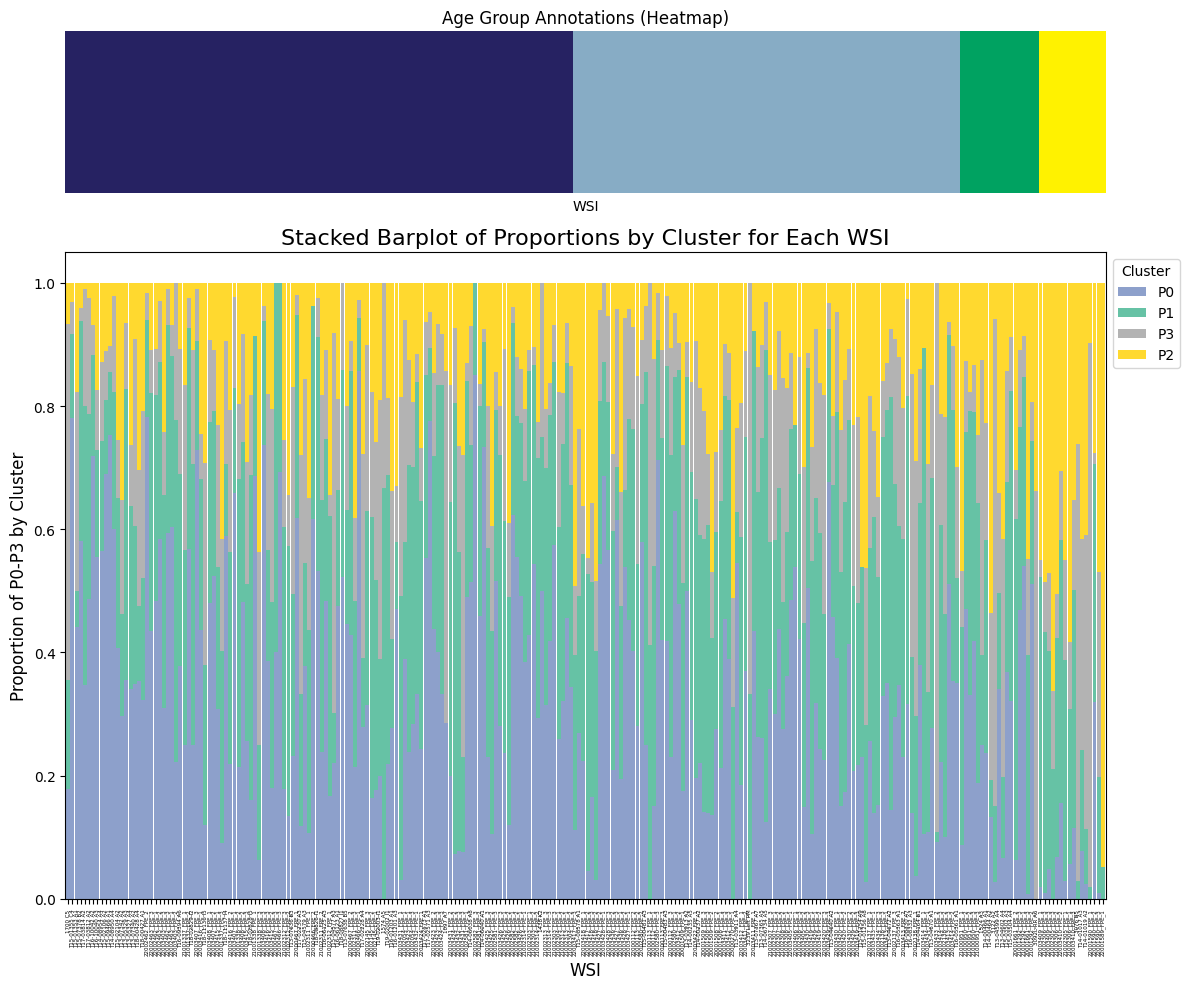

In [30]:
# visualise abundance of ageing-associated phenotypes of each slide in the test_BRCA dataset
BRCA_df = pd.read_csv(f"{save_prefix}/test_BRCA_tsne_4clusters.csv")
plot_stacked_bar_and_age_group_annotation(BRCA_df, save_pt=None)

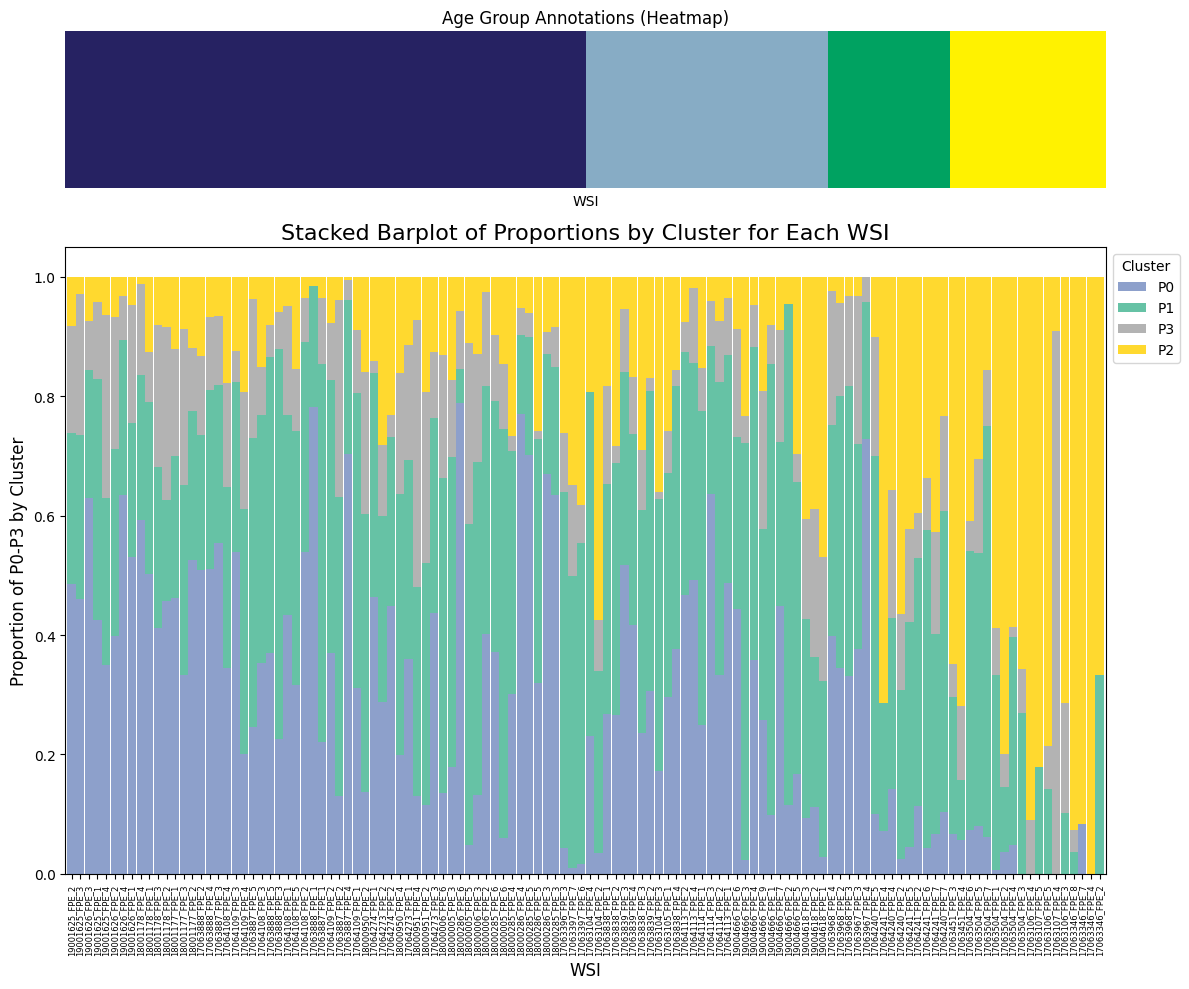

In [28]:
# visualise abundance of ageing-associated phenotypes of each slide in the test_NR dataset
NR_df = pd.read_csv("/scratch/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/figures/Fig5/test_NR_tsne_4clusters.csv")
plot_stacked_bar_and_age_group_annotation(NR_df, save_pt=None)

In [79]:
NR_abundance = NR_df.groupby(['wsi_id', 'age_group', 'Cluster']).size().reset_index(name='Count')
NR_total = NR_abundance.groupby('wsi_id')['Count'].transform('sum')
NR_abundance['Proportion'] = NR_abundance['Count'] / NR_total
NR_abundance['source'] = 'NR'

BRCA_abundance = BRCA_df.groupby(['wsi_id', 'age_group', 'Cluster']).size().reset_index(name='Count')
BRCA_total = BRCA_abundance.groupby('wsi_id')['Count'].transform('sum')
BRCA_abundance['Proportion'] = BRCA_abundance['Count'] / BRCA_total
BRCA_abundance['source'] = 'BRCA'

df_abundance = pd.concat([NR_abundance, BRCA_abundance], axis=0).reset_index(drop=True)
df_abundance

wsi_id  age_group  Cluster  Count  Proportion source
0     17063104_FPE_2          1        0     22    0.034976     NR
1     17063104_FPE_2          1        1    192    0.305246     NR
2     17063104_FPE_2          1        2    362    0.575517     NR
3     17063104_FPE_2          1        3     53    0.084261     NR
4     17063104_FPE_3          1        0    137    0.172762     NR
...              ...        ...      ...    ...         ...    ...
1421    T19-02002 I1          0        3     12    0.125000   BRCA
1422    T19-02003 I1          0        0     20    0.200000   BRCA
1423    T19-02003 I1          0        1     19    0.190000   BRCA
1424    T19-02003 I1          0        2     19    0.190000   BRCA
1425    T19-02003 I1          0        3     42    0.420000   BRCA

[1426 rows x 6 columns]

/tmp/ipykernel_2112822/614536158.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["P0", "P1", "P2", "P3"])
/tmp/ipykernel_2112822/614536158.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["P0", "P1", "P2", "P3"])
/tmp/ipykernel_2112822/614536158.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["P0", "P1", "P2", "P3"])
/tmp/ipykernel_2112822/614536158.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["P0", "P1", "P2", "P3"])


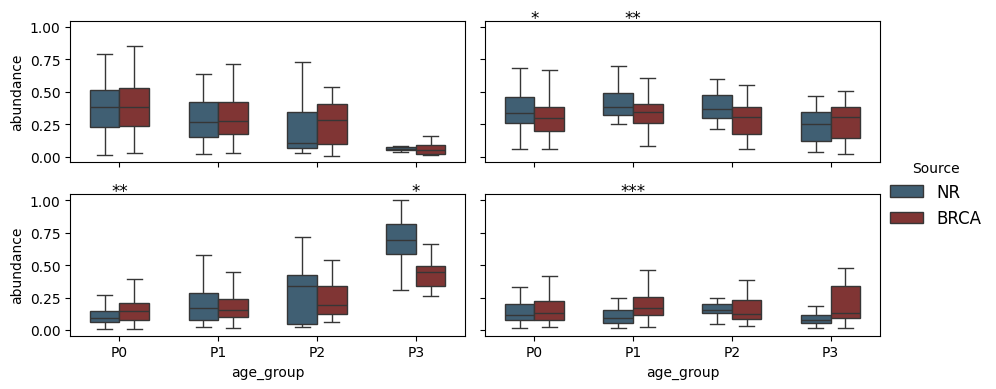

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Create a 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index from 0 to 3

# Loop through clusters to create each subplot
for i, cluster in enumerate([0, 1, 2, 3]):
    ax = axes[i]
    cluster_data = df_abundance[df_abundance['Cluster'] == cluster]
    
    # Create the boxplot for the data with 'age_group' on the x-axis and 'source' as hue
    sns.boxplot(x="age_group", y="Proportion", hue="source", data=cluster_data,
                palette=["#38617B", "#8D2927"], width=0.6, ax=ax, showfliers=False)
    
    # Loop through the age groups to calculate p-value for significance
    for age_group in df_abundance['age_group'].unique():
        group_data = cluster_data[cluster_data['age_group'] == age_group]
        group_nr = group_data[group_data['source'] == 'NR']['Proportion']
        group_brca = group_data[group_data['source'] == 'BRCA']['Proportion']
        
        stat, p_value = mannwhitneyu(group_nr, group_brca, alternative='two-sided')

        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = 'ns'
        
        # Annotate the significance on the whiskers (above the box)
        if significance != 'ns':  # Only annotate significant results
            ax.text(x=age_group, y=1.0, s=significance, ha='center', va='bottom', fontsize=12, color='black')

    # Customize plot appearance
    ax.set_ylabel("abundance", fontsize=10)
    ax.legend().set_visible(False)

    # Customize x-tick labels (assuming `age_group` has values like 'P0', 'P1', 'P2', 'P3')
    ax.set_xticklabels(["P0", "P1", "P2", "P3"])

# Add one shared legend outside the plot for 'source' variable
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Source", loc='center right', fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make space for the legend
save_pt = f"{save_prefix}/boxplots_Phenotype_abundance_median.pdf"
plt.savefig(fname=save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

/tmp/ipykernel_2112822/275614075.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_NR = heatmap_data_NR.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "nan") + '\n' + significance_data_NR
/tmp/ipykernel_2112822/275614075.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_BRCA = heatmap_data_BRCA.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "nan") + '\n' + significance_data_BRCA


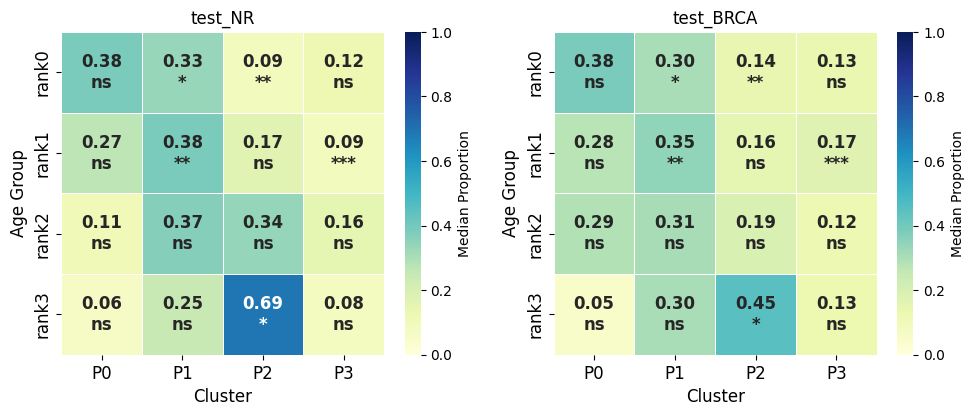

In [100]:
from scipy.stats import mannwhitneyu
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

df_abundance_NR = df_abundance[df_abundance['source'] == 'NR']
df_abundance_BRCA = df_abundance[df_abundance['source'] == 'BRCA']

ordered_age_groups = [0, 1, 2, 3]
clusters = sorted(df_abundance['Cluster'].unique())

heatmap_data_NR = pd.DataFrame(index=ordered_age_groups, columns=clusters)
heatmap_data_BRCA = pd.DataFrame(index=ordered_age_groups, columns=clusters)
significance_data_NR = pd.DataFrame(index=ordered_age_groups, columns=clusters)
significance_data_BRCA = pd.DataFrame(index=ordered_age_groups, columns=clusters)


for cluster in clusters:
    for age_group in ordered_age_groups:
        group_nr = df_abundance_NR[(df_abundance_NR['Cluster'] == cluster) & (df_abundance_NR['age_group'] == age_group)]['Proportion']
        group_brca = df_abundance_BRCA[(df_abundance_BRCA['Cluster'] == cluster) & (df_abundance_BRCA['age_group'] == age_group)]['Proportion']

        if len(group_nr) > 0 and len(group_brca) > 0:
            stat, p_value = mannwhitneyu(group_nr, group_brca, alternative='two-sided')
        else:
            p_value = 1.0

        median_nr = group_nr.median() if len(group_nr) > 0 else np.nan
        median_brca = group_brca.median() if len(group_brca) > 0 else np.nan

        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = 'ns'

        heatmap_data_NR.loc[age_group, cluster] = median_nr
        heatmap_data_BRCA.loc[age_group, cluster] = median_brca
        significance_data_NR.loc[age_group, cluster] = significance
        significance_data_BRCA.loc[age_group, cluster] = significance


annot_NR = heatmap_data_NR.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "nan") + '\n' + significance_data_NR
annot_BRCA = heatmap_data_BRCA.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "nan") + '\n' + significance_data_BRCA


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(
    heatmap_data_NR.astype(float), annot=annot_NR, fmt='', cmap="YlGnBu",
    annot_kws={"size": 12, "weight": "bold"}, ax=axes[0], cbar_kws={'label': 'Median Proportion'},
    cbar=True, linewidths=0.5, square=True, vmin=0, vmax=1
)
axes[0].set_title("test_NR", fontsize=12)
axes[0].set_xlabel("Cluster", fontsize=12)
axes[0].set_ylabel("Age Group", fontsize=12)
axes[0].set_xticklabels([f"P{i}" for i in [0,1,2,3]], fontsize=12)
axes[0].set_yticklabels([f"rank{age}" for age in ordered_age_groups], fontsize=12)

sns.heatmap(
    heatmap_data_BRCA.astype(float), annot=annot_BRCA, fmt='', cmap="YlGnBu",
    annot_kws={"size": 12, "weight": "bold"}, ax=axes[1], cbar_kws={'label': 'Median Proportion'},
    cbar=True, linewidths=0.5, square=True, vmin=0, vmax=1
)
axes[1].set_title("test_BRCA", fontsize=12)
axes[1].set_xlabel("Cluster", fontsize=12)
axes[1].set_ylabel("Age Group", fontsize=12)
axes[1].set_xticklabels([f"P{i}" for i in [0,1,2,3]], fontsize=12)
axes[1].set_yticklabels([f"rank{age}" for age in ordered_age_groups], fontsize=12)

plt.tight_layout()
save_pt = f"{save_prefix}/heatmaps_Phenotype_abundance_median.pdf"
plt.savefig(fname = save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()